1.

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Load Data
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tan5577/heart-failure-dataset")

print("Path to dataset files:", path)

data = pd.read_csv(f"{path}/heart.csv")
data = shuffle(data, random_state=42)

# Get label
target_col = 'HeartDisease'

categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
numeric_features = [col for col in X.columns if col not in categorical_features]

# Split into Train, Validation, and Test sets
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)  # 70% train, 30% temp
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)  # 15% val, 15% test

print(f"Training set: {len(train_data)} samples")
print(f"Validation set: {len(val_data)} samples")
print(f"Test set: {len(test_data)} samples")

# Save splits
train_data.to_csv("heart_data_train.csv", index=False)
val_data.to_csv("heart_data_val.csv", index=False)
test_data.to_csv("heart_data_test.csv", index=False)


Using Colab cache for faster access to the 'heart-failure-dataset' dataset.
Path to dataset files: /kaggle/input/heart-failure-dataset
Training set: 642 samples
Validation set: 138 samples
Test set: 138 samples


Statistical Summary:


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


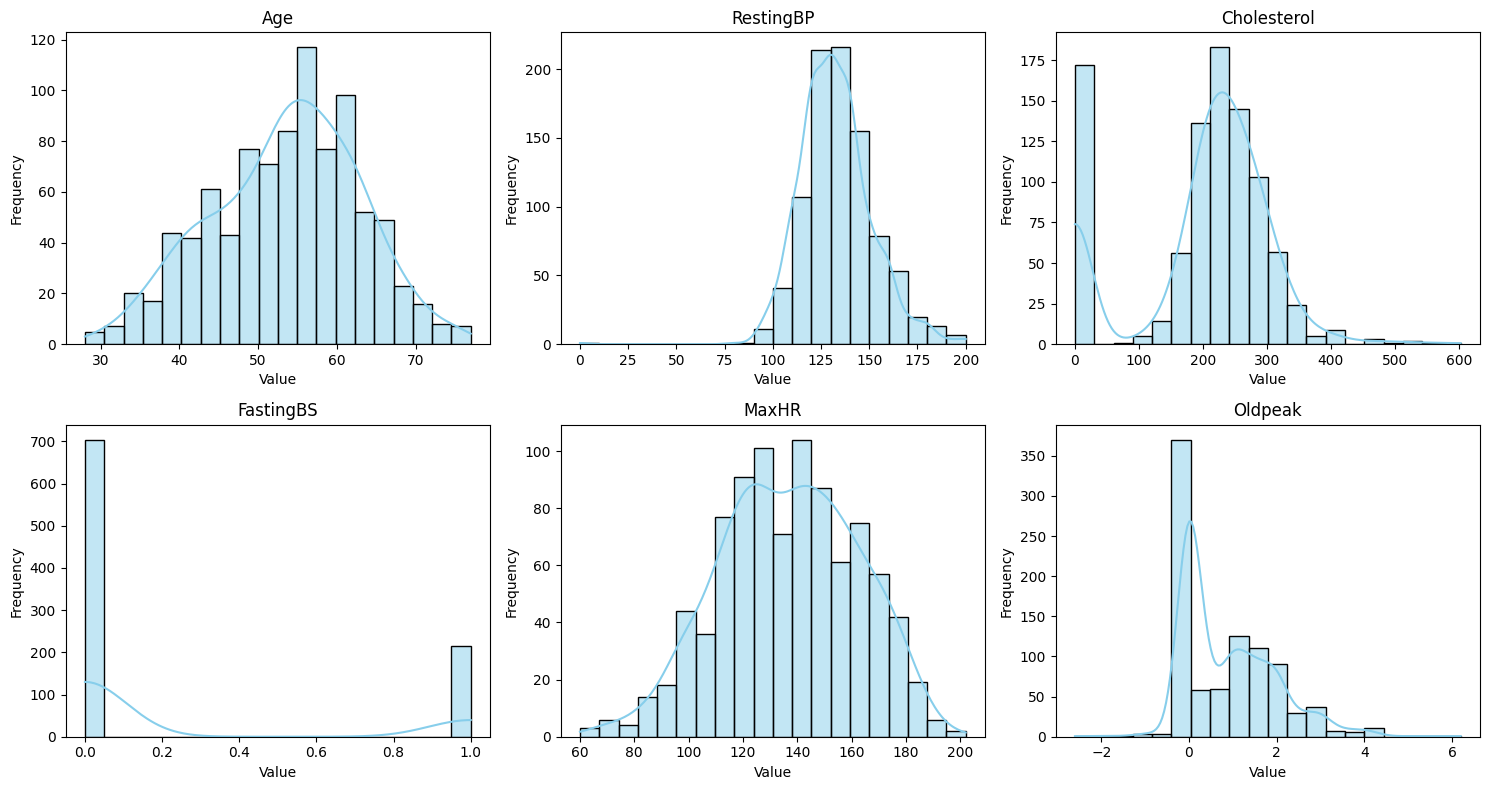

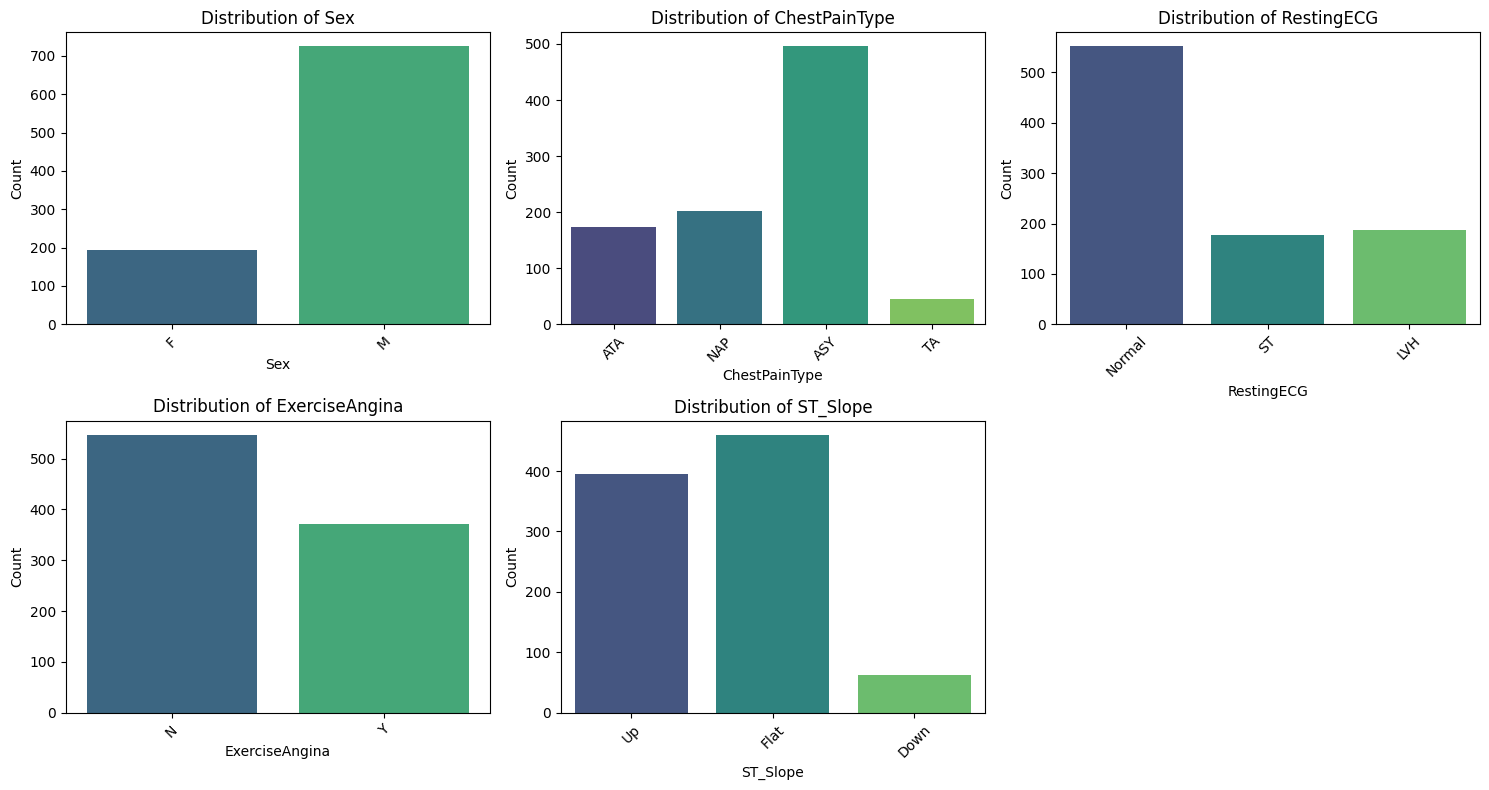

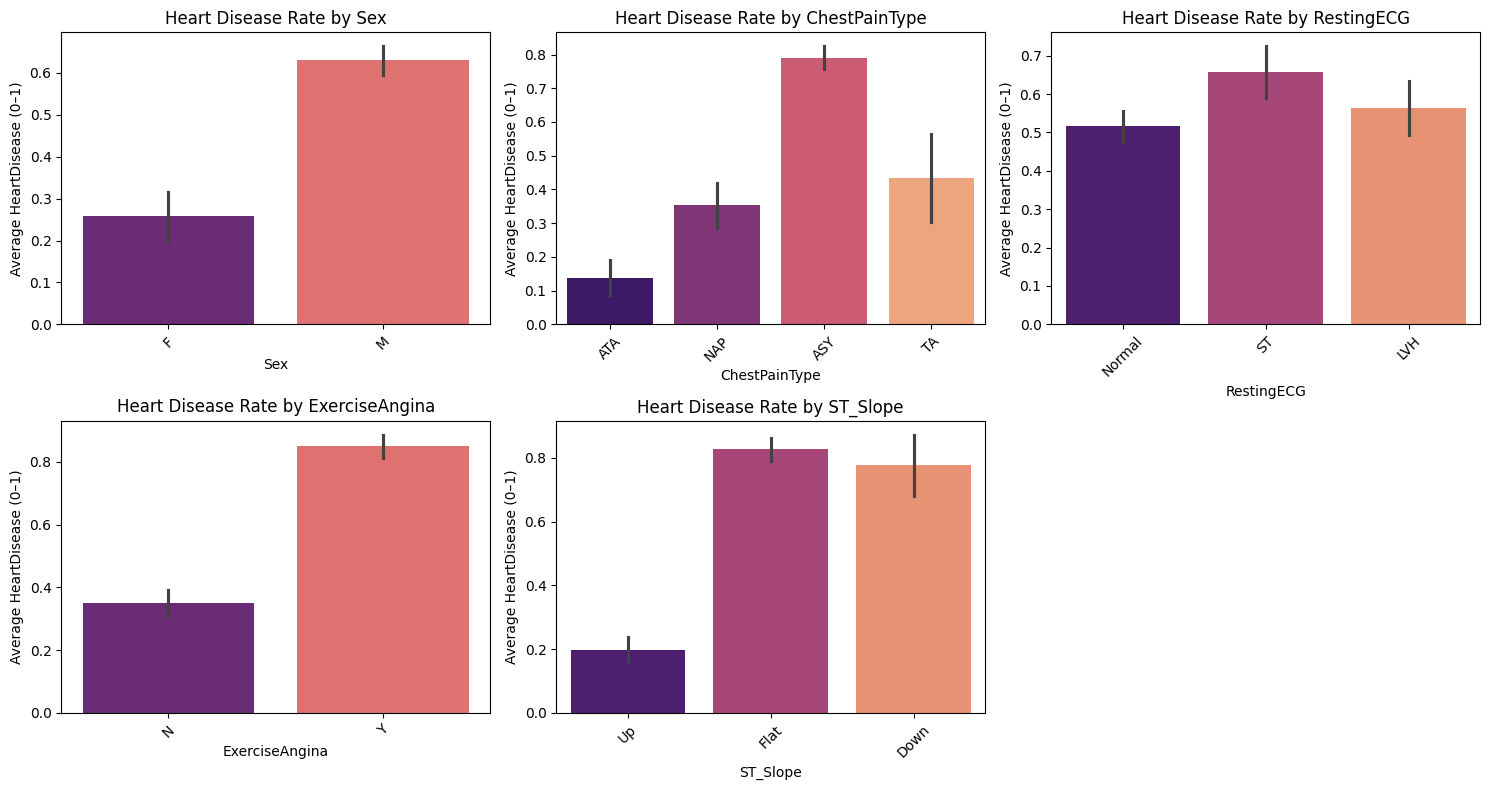

In [59]:
# Statistical Summary
print("Statistical Summary:")
display(data.describe())

# Histograms for Numeric Features (in a grid)
n_num = len(numeric_features)
cols = 3
rows = (n_num // cols) + int(n_num % cols != 0)

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))
axes = axes.flatten()

for i, col in enumerate(numeric_features):
    sns.histplot(data[col], bins=20, kde=True, color='skyblue', ax=axes[i])
    axes[i].set_title(f"{col}")
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Bar Plots for Categorical Features (in a grid)
n_cat = len(categorical_features)
cols = 3
rows = (n_cat // cols) + int(n_cat % cols != 0)

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    sns.countplot(x=col, data=data, palette='viridis', ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Relationship Between Categorical Features and HeartDisease (grid)
n_cat = len(categorical_features)
cols = 3
rows = (n_cat // cols) + int(n_cat % cols != 0)

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    sns.barplot(x=col, y='HeartDisease', data=data, estimator=np.mean, palette='magma', ax=axes[i])
    axes[i].set_title(f"Heart Disease Rate by {col}")
    axes[i].set_ylabel("Average HeartDisease (0–1)")
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


The categorical attributes (Sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope) must be encoded numerically before training. One-hot encoding is the most appropriate choice, as it prevents imposing an artificial order among categories.

Will also do log transforms on the numerical attributes to create more standardized data

In [60]:
# Scaled
preprocessor_scaled = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ]
)

# Unscaled
preprocessor_unscaled = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ]
)

X_train = train_data.drop(columns=[target_col])
y_train = train_data[target_col]
X_test = test_data.drop(columns=[target_col])
y_test = test_data[target_col]

2.

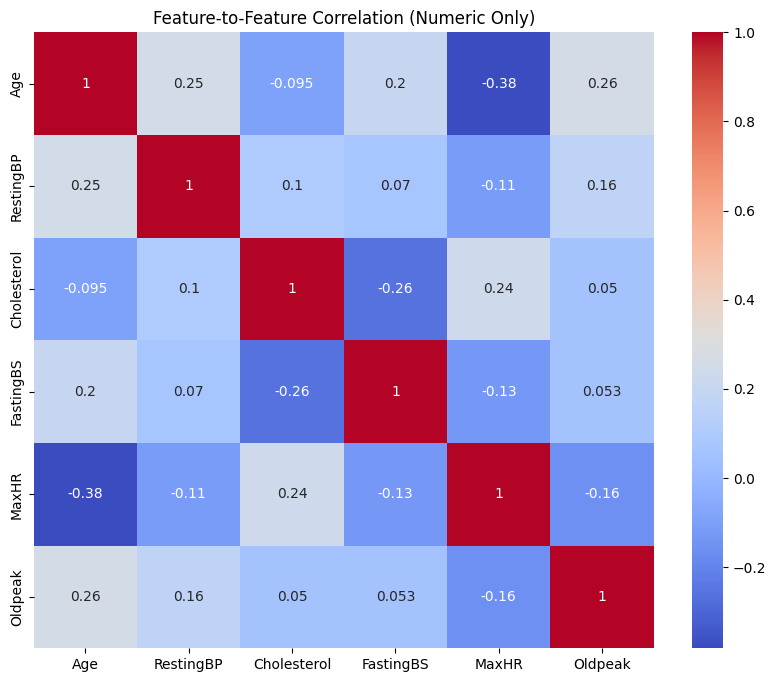

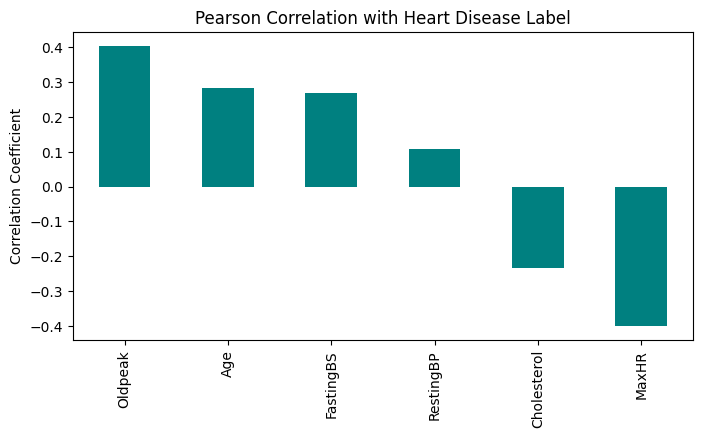

In [61]:

# Pearson Correlation Between Numeric Features
plt.figure(figsize=(10, 8))
sns.heatmap(data[numeric_features].corr(), annot=True, cmap='coolwarm')
plt.title("Feature-to-Feature Correlation (Numeric Only)")
plt.show()

# Correlation with Label (HeartDisease)
label_corr = {}
for col in numeric_features:
    corr, _ = pearsonr(data[col], data['HeartDisease'])
    label_corr[col] = corr

plt.figure(figsize=(8, 4))
pd.Series(label_corr).sort_values(ascending=False).plot(kind='bar', color='teal')
plt.title("Pearson Correlation with Heart Disease Label")
plt.ylabel("Correlation Coefficient")
plt.show()

In [62]:
# More Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Separate features and labels for each split
X_train, y_train = train_data.drop(columns=[target_col]), train_data[target_col]
X_val, y_val = val_data.drop(columns=[target_col]), val_data[target_col]
X_test, y_test = test_data.drop(columns=[target_col]), test_data[target_col]

X_train_scaled = preprocessor_scaled.fit_transform(X_train)
X_val_scaled = preprocessor_scaled.transform(X_val)
X_test_scaled = preprocessor_scaled.transform(X_test)

# Helper function for evaluation
def evaluate_model(model, X_tr, y_tr, X_val, y_val, X_te, y_te):
    # Generate classification reports
    train_report = classification_report(y_tr, model.predict(X_tr), output_dict=True)
    val_report = classification_report(y_val, model.predict(X_val), output_dict=True)
    test_report = classification_report(y_te, model.predict(X_te), output_dict=True)

    # Extract overall metrics
    metrics = pd.DataFrame({
        'Train': [train_report['accuracy'], train_report['macro avg']['precision'], train_report['macro avg']['recall'], train_report['macro avg']['f1-score']],
        'Validation': [val_report['accuracy'], val_report['macro avg']['precision'], val_report['macro avg']['recall'], val_report['macro avg']['f1-score']],
        'Test': [test_report['accuracy'], test_report['macro avg']['precision'], test_report['macro avg']['recall'], test_report['macro avg']['f1-score']]
    }, index=['Accuracy', 'Precision', 'Recall', 'F1-score'])

    print("\nPerformance Summary:")
    display(metrics)

    # Plot metrics
    metrics.T.plot(kind='bar', figsize=(8, 6))
    plt.title("Model Performance Comparison")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.xticks(rotation=0)
    plt.legend(loc='lower right')
    plt.show()


4.

A.

Best Logistic Regression Params: {'C': 10, 'max_iter': 10, 'solver': 'newton-cg'}

Performance Summary:


,Train,Validation,Test
Accuracy,0.870717,0.884058,0.862319
Precision,0.870380,0.883667,0.870528
Recall,0.866974,0.883667,0.852778
F1-score,0.868410,0.883667,0.857647


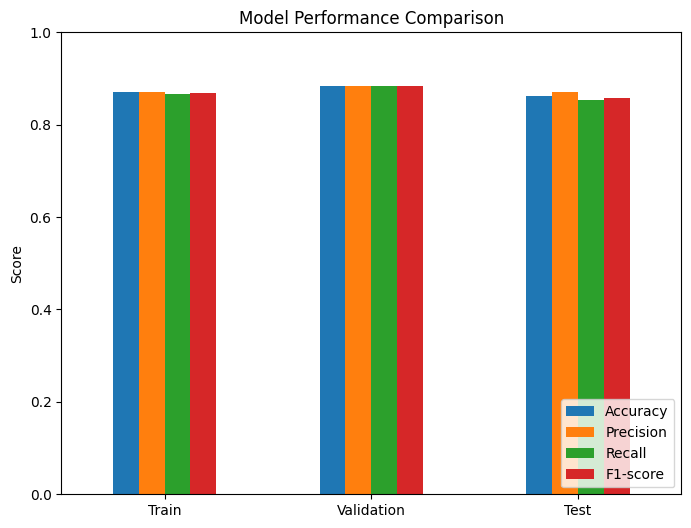

In [63]:
# Logistic Regression (Softmax)
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'saga', 'liblinear', 'newton-cg'],
    'max_iter': [10, 25, 50, 100, 200, 500, 1000]
}

lr = LogisticRegression(multi_class='multinomial')
grid_lr = GridSearchCV(lr, param_grid_lr, cv=3, scoring='accuracy')
grid_lr.fit(X_train_scaled, y_train)

print("Best Logistic Regression Params:", grid_lr.best_params_)
best_lr = grid_lr.best_estimator_

evaluate_model(best_lr, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

Hyper Parameters:
---------------------
C: Controls trade-off of regularization

- Smaller C = stronger regularization -> less overfitting but possible underfitting

- Larger C = weak regularization -> better fit training data but risk of overfit


Solver: Determines the optimization algorithm

- liblinear: best for snall datasets and binary classification

- lbfgs: Supports L2 regularization, good for medium/large datasets

- newton-cg:best for large datasets and multiclass classification, supports l2 regularization

- saga: Supports l1,l2, and elastic-net regularization



Max Number of Iterations: how ling solver runs

- if too low, the model may not converge and underfit

- if too high the model could run for too long




B.

Best SVM Params: {'C': 0.1, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}

Performance Summary:


,Train,Validation,Test
Accuracy,0.875389,0.884058,0.847826
Precision,0.873182,0.887039,0.849303
Recall,0.875531,0.887039,0.841495
F1-score,0.874139,0.884058,0.844219


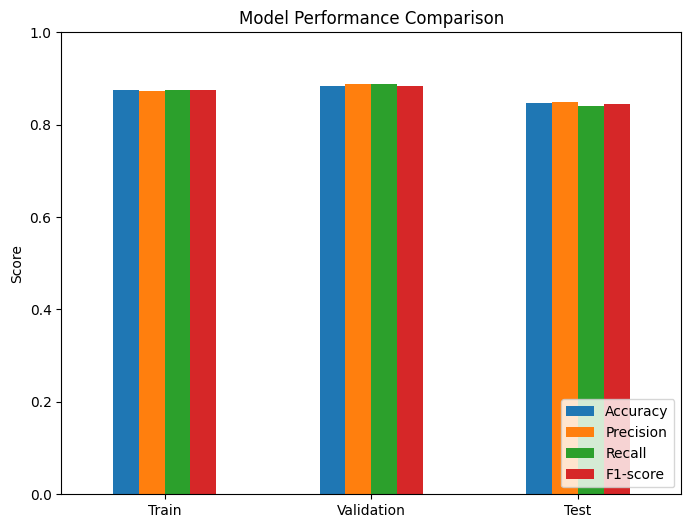

In [64]:
# SVM with Grid Search
param_grid_svm = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto']
}

svm = SVC(probability=True)
grid_svm = GridSearchCV(svm, param_grid_svm, cv=3, scoring='accuracy')
grid_svm.fit(X_train_scaled, y_train)

print("Best SVM Params:", grid_svm.best_params_)
best_svm = grid_svm.best_estimator_

evaluate_model(best_svm, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)


Hyper Parameters
---------------------

C: regularization

- low C = more tolerance for missclassification/wider margin may underfit

- high C = smaller margin so less tolerance and may overfit

Kernel: transforms data into higher dimensions where it becomes linearly separable, allowing a standard linear classifier to find a decision boundary


Degree: Cotnrols the complexitiy of the polynomial kernel

- hgiher degree = more complex decision boundaries can possibly overfit data

Gamma: How far the influence of a training example reaches

- Low gamma = smoother decision boundary

- High gamma = more complex nboundary where it runs the reisk of overfitting

C.

Best Random Forest Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Performance Summary:


,Train,Validation,Test
Accuracy,1.0,0.862319,0.847826
Precision,1.0,0.864744,0.855098
Recall,1.0,0.859747,0.838088
F1-score,1.0,0.861086,0.842662


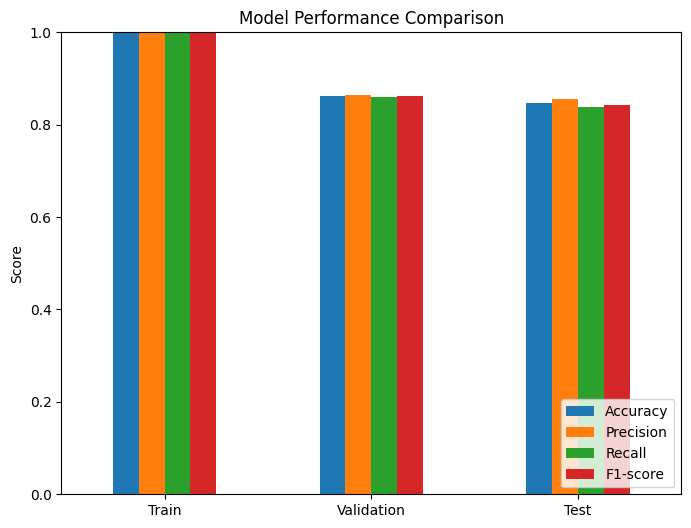

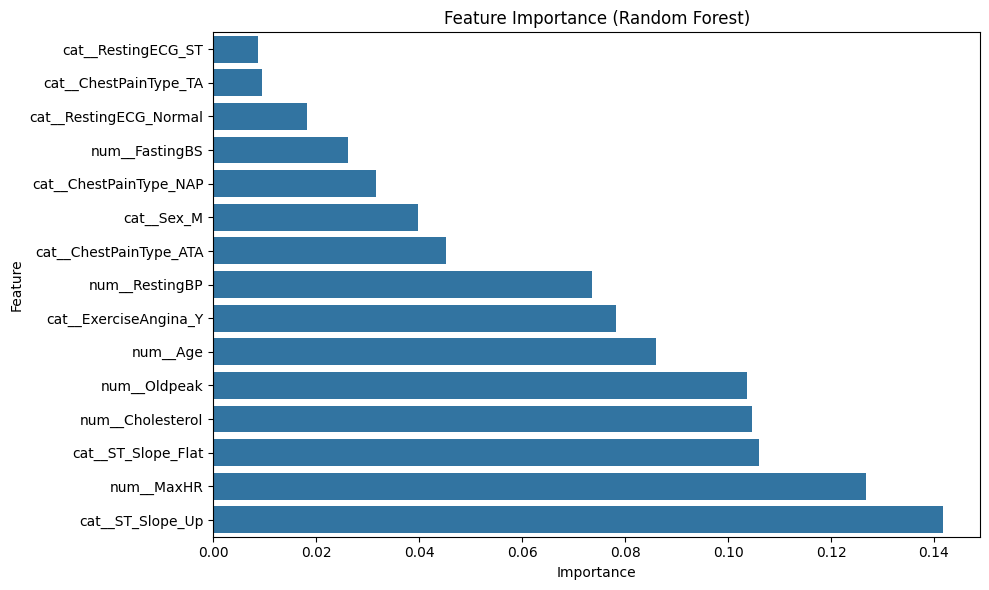

In [65]:
# Random Forest with Grid Search
param_grid_rf = {
    'n_estimators': [10 ,25, 50, 100, 200],
    'max_depth': [None, 2, 5, 10, 20, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 5, 10]
}

rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='accuracy')
grid_rf.fit(X_train_scaled, y_train)

print("Best Random Forest Params:", grid_rf.best_params_)
best_rf = grid_rf.best_estimator_

evaluate_model(best_rf,  X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

# Feature importance
feature_names = preprocessor_scaled.get_feature_names_out()
importances = best_rf.feature_importances_
sorted_idx = np.argsort(importances)
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[sorted_idx], y=feature_names[sorted_idx], orient='h')
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()



Hyper Parameters
-----------------

Number of trees (n_estimators):

- The more trees, possible better performance

- helps reduce the variance

Max depth: limit of tree depth

- shallow: possible risk of underfitting

- Deep: risk of overfitting

Min samples to split: minimum samples required to split a node

- higher values is a more conservative split which can reduce overfitting

Min samples at leaf: minimum samples required at a leaf node

- this helps prevent very specific rules that can cause overfitting



5. Ensembles

Hard Voting Ensemble

Ensemble Performance on Validation Set:

Performance Summary:


,Train,Validation,Test
Accuracy,0.901869,0.876812,0.862319
Precision,0.900661,0.876471,0.867063
Recall,0.900366,0.877661,0.854482
F1-score,0.900511,0.876650,0.858385


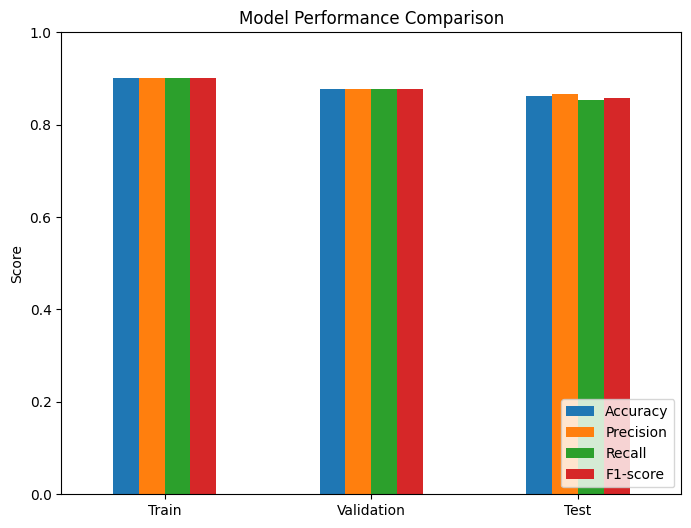

In [66]:
from sklearn.ensemble import VotingClassifier

# Create ensemble using the best models found from GridSearch
ensemble = VotingClassifier(
    estimators=[
        ('lr', best_lr),
        ('svm', best_svm),
        ('rf', best_rf)
    ],
    voting='hard'
)

# Train ensemble on training set
ensemble.fit(X_train_scaled, y_train)

# Evaluate on validation set first
print("Ensemble Performance on Validation Set:")
evaluate_model(ensemble, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

Soft Voting Ensemble

Soft Voting Ensemble Performance:

Performance Summary:


,Train,Validation,Test
Accuracy,0.903427,0.891304,0.891304
Precision,0.902937,0.890966,0.897487
Recall,0.901035,0.892202,0.883862
F1-score,0.901904,0.891161,0.888199


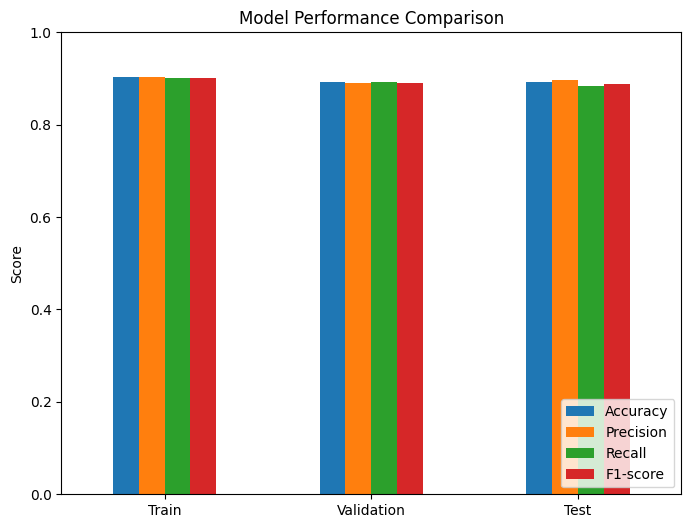

In [67]:
# Enable probability for SVM
svm_soft = SVC(C=best_svm.C, kernel=best_svm.kernel, degree=best_svm.degree,
               gamma=best_svm.gamma, probability=True)

ensemble_soft = VotingClassifier(
    estimators=[
        ('lr', best_lr),
        ('svm', svm_soft),
        ('rf', best_rf)
    ],
    voting='soft',
    weights=[2, 1, 1]
)

ensemble_soft.fit(X_train_scaled, y_train)

print("Soft Voting Ensemble Performance:")
evaluate_model(ensemble_soft, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

Stacking Ensemble (Best)

Stacking Ensemble Performance:

Performance Summary:


,Train,Validation,Test
Accuracy,0.922118,0.884058,0.891304
Precision,0.922743,0.883540,0.897487
Recall,0.919250,0.884510,0.883862
F1-score,0.920762,0.883838,0.888199


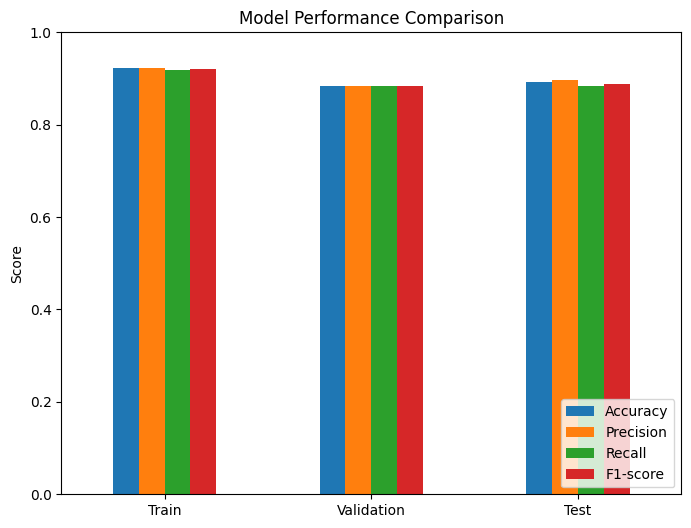

In [68]:
from sklearn.ensemble import StackingClassifier

# Meta-classifier: Logistic Regression
stacking = StackingClassifier(
    estimators=[
        ('lr', best_lr),
        ('svm', best_svm),
        ('rf', best_rf)
    ],
    final_estimator=LogisticRegression(max_iter=500)
)

stacking.fit(X_train_scaled, y_train)

print("Stacking Ensemble Performance:")
evaluate_model(stacking, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

Stacking and soft voting ensembles both performed equally well on the test data set